# Minimal Lasagne Demo (multilayer perceptron)
In this script we build a small multilayer perceptron with two hidden layers having 500 and 50 neurons each for classifying the MNIST database of handwritten digits.  


## Loading the data
While the original dataset has 70'000 examples of hand written digits (see below for loading) we restrict us here to the first 4000 digits so that an interactive session is possible. The subset of the first 4000 MNIST examples is provided in the repository for convenience. 

### Data-Format
For Lasagne all images must be provided in a 4-dimensional array X with the following dimensions (number of images, number of colors, x, y) and the labels in a vector y of same size. So X[1,0,1,2] would be the image number 1, the color channel 0 and the pixel x = 1 and y=2.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot

import cPickle as pickle
import gzip
with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

In [13]:
X[0,0,15,16] 

1.0584806

In [3]:
#from create_mnist import load_data_2d
#X,y,PIXELS = load_data_2d('/home/dueo/dl-playground/data/mnist.pkl.gz')
#X.shape, y

### Normalization of the data
The data is normalized so that each pixel has mean 0 and standard deviation close to 1 (calculated over all images). This has been done with the following code (the 0th axis is along the images): 
```
    Xmean = X.mean(axis = 0)
    XStd = np.sqrt(X.var(axis=0))
    X = (X-Xmean)/(XStd + 0.01)
```
Note that with this normalization the mean values of all pixels of a single image need not be 0.


In [3]:
np.mean(X[0,0,:,:]),np.mean(X[:,0,1,1]),np.mean(X[:,0,2,1]),np.var(X[:,0,10,10])

(0.046298616, 0.0, 0.0, 0.93183041)

##### Let s plot the first few images and label

In [4]:
y[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

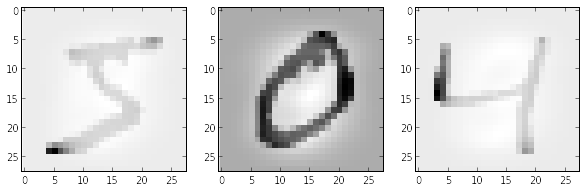

In [5]:
fig = plt.figure(figsize=(10,30))
for i in range(3):
    a=fig.add_subplot(1,3,(i+1))
    plt.imshow(-X[i,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

Note that the backgound is not uniform. That is due to the batchnormalization.

### Our first simple network
Let's define a MLP. First we load the necessary libraries and then define the network. 
#### Definition of the network
There are several ways to define a network in Lasagne. We use the easiest method using the `NeuralNet` class from the `nolearn.lasagne` package. Other ways are detailed in the examples [https://github.com/Lasagne/Lasagne/blob/master/examples/]
 of the Lasagne library. 


In [14]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    hidden1_num_units=500,
    hidden2_num_units=50,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=100,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 

After the definition of the network the network has to be trained. Therefore the data is split automatically into 80% training set and 20% test set (controlled by `eval_size=0.2`). Since it takes quite a while to finish an epoch (at least with a CPU), we reduce the data to 1000 samples (800 for training and 200 for testing).

In [15]:
net = net1.fit(X[0:1000,:,:,:],y[0:1000])

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 50)          	produces      50 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.187187  |    1.725215  |     1.267776  |     50.21%  |  0.1s
     2  |    1.230878  |    1.118347  |     1.100622  |     72.76%  |  0.1s
     3  |    0.685538  |    0.766687  |     0.894156  |     76.81%  |  0.1s
     4  |    0.419294  |    0.609308  |     0.688148  |     79.44%  |  0.1s
     5  |    0.292125  |    0.533182  |     0.547890  |     82.32%  |  0.1s
     6  |    0.218402  |    0.497920  |     0.438629  |     83.49%  |  0.1s
     7  |    0.170713  |    0.477360  |     0.357619  |     83.49%  |  0.1s
     8  |    0.137487  |    0.464683  |     0.2

As a remark, trainig longer 100 epochs and with 50k of the data, we get about 97.36% accuracy.

We have a trained classifier with which we can make predictions.

### Evaluate the model
Now that we have fixed the weights of the network, we can make predictions on unseen data. We have trained only on the images 0-1000 so let's take the images 1001 to 1021 and do a prediction.  

Note that the softmax layer assigns the following probabilities to the for the classes $i = 0,1,\ldots,9$ 

$
   p_i(\text{input image}) =  \frac{e^{z_i}}{\sum_{j=0}^9 e^{z_j}}
$

which he can obtain for a set of indices like via `net.predict_proba(X[toTest,:,:,:])`. The index with maximum probability is the predicted class and can be obtained by `net1.predict(X[toTest,:,:,:])`.

In [25]:
toTest = range(1001,1026) #Some indices we would like to have a look into
preds = net1.predict(X[toTest,:,:,:])
print(preds) #The predictions for the different classes 
print(net.predict_proba(X[toTest,:,:,:])[0:4]) #The probabilities from the softmax layer.
np.argmax(net.predict_proba(X[toTest,:,:,:])[0])

[7 1 1 4 9 9 3 4 8 2 2 1 8 9 5 8 1 0 0 6 3 7 4 4 8]
[[  1.16831124e-07   3.81061155e-10   3.81762622e-09   8.92168191e-06
    1.19226058e-06   3.25291012e-07   1.48419343e-09   9.99690592e-01
    1.50690425e-06   2.97322345e-04]
 [  2.66134011e-05   9.92980063e-01   3.18128965e-04   2.64594867e-03
    1.99262358e-04   2.17088521e-03   6.98537100e-04   3.64902604e-04
    5.20152273e-04   7.54903667e-05]
 [  2.80395199e-07   9.99716640e-01   6.89360095e-05   1.82905078e-05
    3.75537979e-06   7.27575934e-06   1.88080285e-05   1.65428048e-06
    1.63609468e-04   7.55169822e-07]
 [  5.20743022e-04   2.59210542e-02   2.27144058e-03   2.16244701e-02
    4.05155212e-01   1.31634623e-01   3.96082038e-03   3.16489488e-02
    5.45846894e-02   3.22678000e-01]]


7

####Let's look at the correponding images.
Shown is the predicted value and the true value in parenthesis.

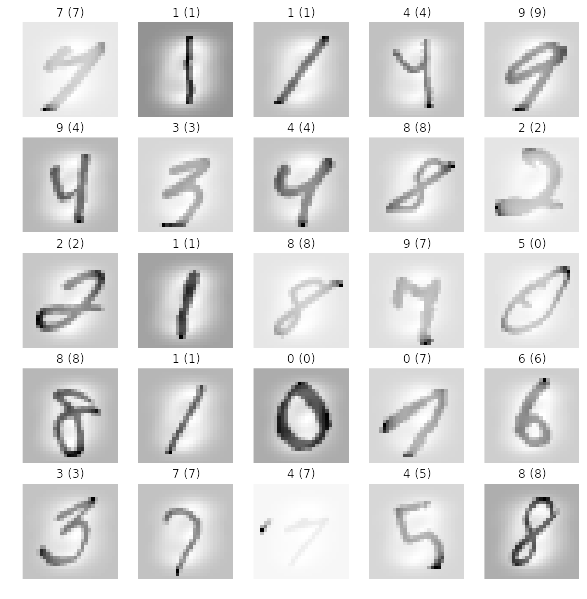

In [21]:
fig = plt.figure(figsize=(10,10))
for i,num in enumerate(toTest):
    a=fig.add_subplot(5,5,(i+1)) #NB the one based API sucks!
    plt.axis('off')
    a.set_title(str(preds[i]) + " (" + str(y[num]) + ")")
    plt.imshow(-X[num,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

#### Evaluation
To evaluate the performance, we take all the unused data (starting from index 1000) in the training and compare their prediction to the true numbers stored in `y`. 

In [39]:
np.sum(net.predict(X[1000:,:,:,:]) == y[1000:]) / (len(y) - 1000.0)

0.87666666666666671

Using the simple approch we get a performence of approx. 88% which is similar to the accuracy calculated on the validation set 86%.

In the notebook [MinimalLasagneCNN.ipynb](MinimalLasagneCNN.ipynb) we show how to use a CNN.